# Tensorflow Convnet #

In [1]:
# matplotlib inline command allows us to see right below the code.
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
import input_data
import warnings # Ignore dumb warnings about deprecation I'll worry about this when I'm dead
warnings.filterwarnings('ignore')

# Stuff for the plt figures
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print("trX.shape", trX.shape)
print("trY.shape", trY.shape)
print("teX.shape", teX.shape)
print("teY.shape", teY.shape)

trX.shape (55000, 784)
trY.shape (55000, 10)
teX.shape (10000, 784)
teY.shape (10000, 10)


In [4]:
# Turn some into validation: We want 1/5th
FRACTION_VAL = 5

N,D = trX.shape
seq = np.array(range(N))
np.random.shuffle(seq)

X_train = trX[seq[N/FRACTION_VAL:]]
y_train = trY[seq[N/FRACTION_VAL:]]
X_val = trX[seq[:N/FRACTION_VAL]]
y_val = trY[seq[:N/FRACTION_VAL]]

print("X_train.shape" , X_train.shape)
print("X_val.shape" , X_val.shape)
print("y_train.shape" , y_train.shape)
print("y_val.shape" , y_val.shape)

X_train.shape (44000, 784)
X_val.shape (11000, 784)
y_train.shape (44000, 10)
y_val.shape (11000, 10)


Labels, in order:  [7 4 5 3 9 2 4 2 7 0]


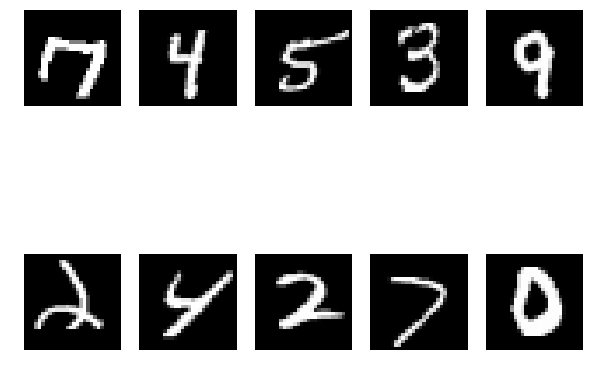

In [5]:
# Let's try to visualize some of these. The format of the images are 28x28.
SHOW_IMAGE = 10

for i in range(SHOW_IMAGE):
    plt.subplot(SHOW_IMAGE/5, SHOW_IMAGE/2, i+1)
    implot = plt.imshow(X_train[i].reshape((28,28)))
    plt.axis('off')

print("Labels, in order: ", np.where(y_train[:i+1] == 1)[-1])

In [6]:
# Taken from Stack Overflow, a batch normalizer.
class ConvolutionalBatchNormalizer(object):
    """Helper class that groups the normalization logic and variables.        

    Use:                                                                      
      ewma = tf.train.ExponentialMovingAverage(decay=0.99)                  
      bn = ConvolutionalBatchNormalizer(depth, 0.001, ewma, True)           
      update_assignments = bn.get_assigner()                                
      x = bn.normalize(y, train=training?)                                  
      (the output x will be batch-normalized).                              
    """

    def __init__(self, depth, epsilon, ewma_trainer, scale_after_norm):
        self.mean = tf.Variable(tf.constant(0.0, shape=[depth]),
                                trainable=False)
        self.variance = tf.Variable(tf.constant(1.0, shape=[depth]),
                                    trainable=False)
        self.beta = tf.Variable(tf.constant(0.0, shape=[depth]))
        self.gamma = tf.Variable(tf.constant(1.0, shape=[depth]))
        self.ewma_trainer = ewma_trainer
        self.epsilon = epsilon
        self.scale_after_norm = scale_after_norm

    def get_assigner(self):
        """Returns an EWMA apply op that must be invoked after optimization."""
        return self.ewma_trainer.apply([self.mean, self.variance])

    def normalize(self, x, train=True):
        """Returns a batch-normalized version of x."""
        if train:
            mean, variance = tf.nn.moments(x, [0, 1, 2])
            assign_mean = self.mean.assign(mean)
            assign_variance = self.variance.assign(variance)
            with tf.control_dependencies([assign_mean, assign_variance]):
                return tf.nn.batch_norm_with_global_normalization(
                    x, mean, variance, self.beta, self.gamma,
                    self.epsilon, self.scale_after_norm)
        else:
            mean = self.ewma_trainer.average(self.mean)
            variance = self.ewma_trainer.average(self.variance)
            local_beta = tf.identity(self.beta)
            local_gamma = tf.identity(self.gamma)
            return tf.nn.batch_norm_with_global_normalization(
              x, mean, variance, local_beta, local_gamma,
              self.epsilon, self.scale_after_norm)

In [7]:
# Now let's build a neural network for this!
# We have the architecture CONV -> RELU -> FC -> RELU -> FC -> SOFTMAX

# Jupyter specific command
tf.reset_default_graph()

def init_weight(shape, std = 0.01):
    return tf.Variable(tf.random_normal(shape, std))

def init_model(params):
    X, W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, conv_dropout, fc_dropout, train_batch = params
    
    ##### STARTING CONV #####
    ## Layer 0 ##
    # First we want to CONV the X to conv_1
    conv_0 = tf.nn.conv2d(X, W0, [1,1,1,1], padding='SAME')
    conv_0 = tf.nn.bias_add(conv_0, b0)
    # Batch norm
    ewma_0 = tf.train.ExponentialMovingAverage(decay=0.99)                  
    bn_0 = ConvolutionalBatchNormalizer(64, 0.001, ewma_0, True)           
    update_assignments_0 = bn_0.get_assigner()                                
    batch_0 = bn_0.normalize(conv_0, train=train_batch)
    
    relu_0 = tf.nn.relu(batch_0)
    drop_0 = tf.nn.dropout(relu_0, conv_dropout)
    
    ## Layer 1 ##
    # Then, we want to CONV the conv_1 to conv_2
    conv_1 = tf.nn.conv2d(drop_0, W1, [1,1,1,1], padding='SAME')
    conv_1 = tf.nn.bias_add(conv_1, b1)

    # Batch norm
    ewma_1 = tf.train.ExponentialMovingAverage(decay=0.99)                  
    bn_1 = ConvolutionalBatchNormalizer(64, 0.001, ewma_1, True)           
    update_assignments_1 = bn_1.get_assigner()                                
    batch_1 = bn_1.normalize(conv_1, train=train_batch)
    relu_1 = tf.nn.relu(batch_1)
    drop_1 = tf.nn.dropout(relu_1, conv_dropout)
    
    ## Layer 2 ##
    # Then, we want to POOL the conv_2
    pool_1 = tf.nn.max_pool(relu_1, [1,2,2,1], [1,2,2,1], padding='SAME')
    
    # Then, we want to CONV the pool_2 to conv_3
    conv_2 = tf.nn.conv2d(pool_1, W2, [1,1,1,1], padding='SAME')
    conv_2 = tf.nn.bias_add(conv_2, b2)

    # Batch norm
    ewma_2 = tf.train.ExponentialMovingAverage(decay=0.99)                  
    bn_2 = ConvolutionalBatchNormalizer(128, 0.001, ewma_2, True)           
    update_assignments_2 = bn_2.get_assigner()                                
    batch_2 = bn_2.normalize(conv_2, train=train_batch)
    
    relu_2 = tf.nn.relu(batch_2)
    drop_2 = tf.nn.dropout(relu_2, conv_dropout)
    
    ## Layer 3 ##
    # Then, we want to POOL the conv_3
    pool_2 = tf.nn.max_pool(relu_2, [1,2,2,1], [1,2,2,1], padding='SAME')
    
    # Then, we want to CONV the pool_3
    conv_3 = tf.nn.conv2d(pool_2, W3, [1,1,1,1], padding='SAME')
    conv_3 = tf.nn.bias_add(conv_3, b3)

    # Batch norm
    ewma_3 = tf.train.ExponentialMovingAverage(decay=0.99)                  
    bn_3 = ConvolutionalBatchNormalizer(64, 0.001, ewma_3, True)           
    update_assignments_3 = bn_3.get_assigner()                                
    batch_3 = bn_3.normalize(conv_3, train=train_batch)
    
    relu_3 = tf.nn.relu(batch_3)
    drop_3 = tf.nn.dropout(relu_3, conv_dropout)

    
    ##### STARTING FC #####
    # Then we need to unroll this result and start FC
    fc_3 = tf.reshape(drop_3, [-1, 7*7*64])
    fc_4 = tf.matmul(fc_3, W4)
    fc_4 += b4

    # Batch norm
#     ewma_4 = tf.train.ExponentialMovingAverage(decay=0.99)                  
#     bn_4 = ConvolutionalBatchNormalizer(1, 0.001, ewma_4, True)           
#     update_assignments_4 = bn_4.get_assigner()                                
#     batch_4 = bn_4.normalize(fc_4, train=train_batch)
    
    relu_4 = tf.nn.relu(fc_4)
    drop_4 = tf.nn.dropout(relu_4, fc_dropout)
    
    # Then we need to fc again to get the result
    fc_5 = tf.matmul(relu_4, W5)
    fc_5 += b5

    answer = fc_5
    return answer

In [8]:
# Variable is a starting point. tf.random_normal initializes it for us with a stddev
input_shape = X_train.shape
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.float32, [None, 10])

############################# CONVOLUTIONAL LAYER INITIALIZATION #############################
# Each layer is in the form of [NxHxWxC]
# We start off with a layer of [Nx28x28x1]
# We change it to a layer of [Nx28x28x64] from CONV a filter of [3x3], padding 1
# Therefore, we need the weight [filter_height = 3, filter_width = 3, in_channels = 1, out_channels = 64]
W0 = init_weight([3,3,1,64])
b0 = init_weight([64])
# Then, we change it to a layer of [Nx28x28x64] from CONV a filter of [3x3], padding 1
# Therefore, we need the weight [filter_height = 3, filter_width = 3, in_channels = 64, out_channels = 64
W1 = init_weight([3,3,64,64])
b1 = init_weight([64])

# Then, we change it to a layer of [Nx14x14x64] from POOLING with filter of [2x2] with stride 2
# No weights necessary.

# Then, we change it to a layer of [Nx14x14x64] from CONV with a filter of [3x3], padding 1
# Therefore, we need the weight [filter_height = 3, filter_width = 3, in_channels = 64, out_channels = 128]
W2 = init_weight([3,3,64,128])
b2 = init_weight([128])

# Then, we get the layer of [Nx7x7x128] from POOLING with filter of [2x2] with stride 2
# No weights necessary.

# Then, we get the layer of [Nx7x7x64] from CONV with a filter of [3x3], padding 1
# Therefore, we need the weight [filter_height = 3, filter_width = 3, in_channels = 128, out_channels = 64]
W3 = init_weight([3,3,128,64])
b3 = init_weight([64])

################################################################################################

############################# FULLY CONNECTED LAYERS INITIALIZATION #############################
# We need to unroll the parameters of the CONV layer, and we get an input of [Nx(7x7x64)]
W4 = init_weight([7*7*64, 300])
b4 = init_weight([1])

# Then, we do one more FC before we feed into softmax:
W5 = init_weight([300, 10])
b5 = init_weight([1])
################################################################################################

#################################### EXTRA PARAMETERS ####################################
conv_dropout = tf.placeholder(tf.float32)
fc_dropout = tf.placeholder(tf.float32)
train_batch = tf.placeholder(tf.bool)

In [9]:
# Hyperparams:
start_learning_rate = 5e-4
reg_rate = 1e-3
decay_steps = 100
decay_rate = 0.90
global_step = tf.Variable(0, trainable=False)


hypothesis = init_model((X, W0, b0, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, conv_dropout, fc_dropout, train_batch))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(hypothesis, y))

# Regularization 
cross_entropy += reg_rate * (tf.nn.l2_loss(W0)+tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)
                             +tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)+tf.nn.l2_loss(W5))

# We want to decay the learning rate 
learning_rate = tf.train.exponential_decay(start_learning_rate, 
                                           global_step, 
                                           decay_steps, 
                                           decay_rate, 
                                           staircase=False, name=None)

# Using Adam to optimize
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
predict_op = tf.argmax(hypothesis, 1)

# Let's log it to see our progress!
loss_summary = tf.scalar_summary('loss', cross_entropy)

# Reshape the matrices into the correct conv dimensions:
X_train = X_train.reshape(-1,28,28,1)
X_val = X_val.reshape(-1,28,28,1)
teX = teX.reshape(-1,28,28,1)

In [ ]:
saver = tf.train.Saver()

# Launch the graph in a session
with tf.Session() as sess:
    # If we have the max model saved
    max_acc = 0
    try:
        saver.restore(sess, "best_model.ckpt")
        max_acc = np.mean(np.argmax(y_val[test_indices], axis=1) ==
                             sess.run(predict_op, feed_dict={X: X_val[test_indices],
                                                             y: y_val[test_indices],
                                                             conv_dropout: 1.0,
                                                             fc_dropout: 1.0,
                                                             train_batch: False}))
        print("Getting max accuracy model: ", max_acc)
    # If we already have the model saved
    except:
        print("Was unable to read best_model.ckpt checkpoint. max_acc = 0")
        
    try:
        saver.restore(sess, "model.ckpt")
        print("Starting from model.ckpt checkpoint.")
    except:
        print("Was unable to read model.ckpt checkpoint.")
        # you need to initialize all variables
        init_op = tf.initialize_all_variables()
        sess.run(init_op)
        
    writer = tf.train.SummaryWriter('logs', sess.graph_def)
    
    try:    
        for i in range(100000):
            NUM_BATCHES = 10
            for j in range(NUM_BATCHES):
                batch_mask = np.random.choice(44000, 128)
                summary_str, _, cur_loss = sess.run([loss_summary, train_op, cross_entropy], 
                                                    feed_dict={X: X_train[batch_mask], 
                                                               y: y_train[batch_mask],
                                                               conv_dropout: 0.5, 
                                                               fc_dropout: 0.5,
                                                               train_batch: True})
            print("Current learning_rate : ", learning_rate.eval())
            test_indices = np.arange(len(X_val)) # Get a validation batch
            test_indices = test_indices[0:256]

            writer.add_summary(summary_str, i)
            print("Loss : " , cur_loss)
            acc = np.mean(np.argmax(y_val[test_indices], axis=1) ==
                             sess.run(predict_op, feed_dict={X: X_val[test_indices],
                                                             y: y_val[test_indices],
                                                             conv_dropout: 1.0,
                                                             fc_dropout: 1.0,
                                                             train_batch: False}))
            print(i, acc)
            if acc > max_acc:
                max_acc = acc
                save_path = saver.save(sess, "best_model.ckpt") # checkpoint file
                print("Best model saved in file: %s" % save_path)

    except KeyboardInterrupt:
        print('Interrupted')
        save_path = saver.save(sess, "model.ckpt") # checkpoint file
        print("Model saved in file: %s" % save_path)
        try:
            sys.exit(0)
        except SystemExit:
            os._exit(0)
    save_path = saver.save(sess, "model.ckpt") # checkpoint file
    print("Model saved in file: %s" % save_path)

Was unable to read best_model.ckpt checkpoint. max_acc = 0
Starting from model.ckpt checkpoint.
Current learning_rate :  1.18236e-05
Loss :  564.883
0 0.89453125
Best model saved in file: best_model.ckpt
Current learning_rate :  1.16996e-05
Loss :  598.741
1 0.92578125
Best model saved in file: best_model.ckpt
Current learning_rate :  1.1577e-05
Loss :  605.087
2 0.91796875
Current learning_rate :  1.14557e-05
Loss :  573.351
3 0.94140625
Best model saved in file: best_model.ckpt
Current learning_rate :  1.13356e-05
Loss :  585.392
4 0.91796875
Current learning_rate :  1.12168e-05
Loss :  581.429
5 0.91796875
Current learning_rate :  1.10993e-05
Loss :  582.311
6 0.91015625
Current learning_rate :  1.09829e-05
Loss :  616.586
7 0.921875
Current learning_rate :  1.08678e-05
Loss :  582.129
8 0.91796875
Current learning_rate :  1.07539e-05
Loss :  567.618
9 0.90625
Current learning_rate :  1.06412e-05
Loss :  620.567
10 0.90625
Current learning_rate :  1.05297e-05
Loss :  600.931
11 0.91

Accuracy :  0.94140625
Answers :  [8 6 9 4 5 1 8 9 7 5]


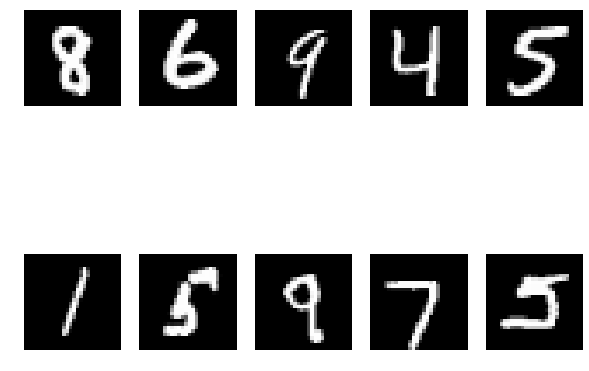

In [22]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "best_model.ckpt")
    
    test_indices = np.arange(len(teX)) # Get a validation batch
    np.random.shuffle(test_indices)

    test_indices = test_indices[0:256]

    acc = np.mean(np.argmax(y_val[test_indices], axis=1) ==
                             sess.run(predict_op, feed_dict={X: X_val[test_indices],
                                                             y: y_val[test_indices],
                                                             conv_dropout: 1.0,
                                                             fc_dropout: 1.0,
                                                             train_batch: False}))

    answers = sess.run(predict_op, feed_dict={X: teX[test_indices],
                                     y: teY[test_indices],
                                     conv_dropout: 1.0,
                                     fc_dropout: 1.0})
    print("Accuracy : " , acc)
    for i in range(SHOW_IMAGE):
        plt.subplot(SHOW_IMAGE/5, SHOW_IMAGE/2, i+1)
        implot = plt.imshow(teX[test_indices[i]].reshape((28,28)))
        plt.axis('off')
    print("Answers : ", answers[:SHOW_IMAGE])